In [1]:
import torch
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

from utils.beam_search import stable_topk
from utils.data import load_pickle

In [2]:
def adj_matrix_to_list(adj_matrix):
    adj_list = []
    
    for i, row in enumerate(adj_matrix):
        dest = np.argwhere(row>0).flatten()
        src = np.full(dest.size, i)
        
        adj_list.extend(zip(src, dest))
    
    return adj_list

def plot_edge_predictions(coords, pred, target):
    G = nx.from_numpy_array(target)
    pos = dict(enumerate(coords))
    
    pred_edge_list = adj_matrix_to_list(pred)

    nx.draw_networkx(G, pos)
    nx.draw_networkx_edges(G, pos, edgelist=pred_edge_list, edge_color='red', alpha=0.1, width=3)
    
    plt.show()

In [3]:
features, targets, preds = load_pickle("data/preds.pkl")

In [4]:
y_pred = preds[..., 1]
y_pred.shape

torch.Size([64, 20, 20])

In [5]:
coords, demands, dist_mat = features[0], features[1], features[2]

In [6]:
beam_width = 2
num_vehicles = 5

In [7]:
# torch.manual_seed(42)

# y = torch.randn(batch_size, num_nodes, num_nodes, 2).type(torch.float)
# y_pred = torch.nn.functional.softmax(y, dim=3)
# y_pred = y_pred[:, :, :, 1]

In [111]:
class Beamsearch:
    """
    Beam search procedure class.

    References:
        [1]: https://github.com/OpenNMT/OpenNMT-py/blob/master/onmt/translate/beam.py
        [2]: https://github.com/alexnowakvila/QAP_pt/blob/master/src/tsp/beam_search.py
        [3]: https://github.com/chaitjo/graph-convnet-tsp/blob/master/utils/beamsearch.py
    """

    def __init__(self, trans_probs, beam_width=1, demands=None, num_vehicles=1, vehicle_capacity=1, 
                 random_start=False, allow_consecutive_depot_visits=True):
        # beam-search parameters
        self.beam_width = beam_width
        self.allow_consecutive_depot_visits = allow_consecutive_depot_visits

        # TODO: Move tensors to GPU device for faster computation
        # tensor data types and device
        self.device = None
        self.float = torch.float32
        self.long = torch.int64

        # all transition probabilities
        self.trans_probs = trans_probs.type(self.float)
        self.demands = demands
        
        self.batch_size = trans_probs.size(0)
        self.num_nodes = trans_probs.size(1)
        self.num_vehicles = num_vehicles
        self.vehicle_capacity = vehicle_capacity

        assert len(trans_probs.shape) == 3, "transition probabilities need to be 3-dimensional"
        assert trans_probs.size(1) == trans_probs.size(2), "transition probabilities are not square"

        if random_start:
            # starting at random nodes
            start_nodes = torch.randint(0, self.num_nodes, (self.batch_size, self.beam_width))
        else:
            # starting at node zero
            start_nodes = torch.zeros(self.batch_size, self.beam_width)

        self.start_nodes = start_nodes.type(self.long)
        self.depot_visits_counter = torch.zeros(self.batch_size, self.beam_width)
        self.remaining_capacity = torch.ones(self.batch_size, self.beam_width) * self.vehicle_capacity

        # mask for removing visited nodes etc.
        self.visited_mask = torch.ones(self.batch_size, self.beam_width, self.num_nodes).type(self.float)

        # transition probability scores up-until current timestep
        self.scores = torch.zeros(self.batch_size, self.beam_width).type(self.float)

        # pointers to parents for each timestep
        self.parent_pointer = []

        # nodes at each timestep
        self.next_nodes = [self.start_nodes]

        # start by masking the starting nodes
        self.update_mask(self.start_nodes)

    @property
    def current_nodes(self):
        """
        Get the nodes to expand at the current timestep
        """
        current_nodes = self.next_nodes[-1]
        current_nodes = current_nodes.unsqueeze(2).expand_as(self.visited_mask)

        return current_nodes

    @property
    def num_iterations(self):
        # -1 for num_nodes because we already start at depot
        # -1 to offset num_vehicles
        return self.num_nodes + self.num_vehicles - 2
    
    @property
    def capacity_mask(self):
        demand = self.demands.unsqueeze(1)
        capacity = self.remaining_capacity.unsqueeze(2)
        
        # batch_size x beam_width x num_nodes (same as visited_mask)
        return torch.le(demand, capacity).type(self.long)
    
    @property
    def mask(self):
        current_mask = self.visited_mask
        
        if self.demands is not None:
            # maybe the capacity masking really isn't needed
            current_mask *= self.capacity_mask
            current_mask[..., 0] = self.capacity_mask[..., 0]
        
        return current_mask

    def search(self):
        """
        Start beam search
        """
        for step in range(self.num_iterations):
            self.step()

    def step(self):
        """
        Transition to the next timestep of the beam search
        """
        current_nodes = self.current_nodes
        trans_probs = self.trans_probs.gather(1, current_nodes)

        if len(self.parent_pointer) == 0:
            # first transition
            beam_prob = trans_probs
            # use only the starting nodes
            beam_prob[:, 1:] = torch.zeros_like(beam_prob[:, 1:])
        else:
            # multiply the previous scores (probabilities) with the current ones
            expanded_scores = self.scores.unsqueeze(2).expand_as(trans_probs)  # b x beam_width x num_nodes
            beam_prob = trans_probs * expanded_scores

        # mask out nodes (based on conditions)
        beam_prob = beam_prob * self.mask
        # beam_prob[..., 0] += 1e-25  # always make the depot slightly available

        beam_prob = beam_prob.view(beam_prob.size(0), -1)  # flatten to (b x beam_width * num_nodes)

        # get k=beam_width best scores and indices (stable)
        best_scores, best_score_idxs = stable_topk(beam_prob, k=self.beam_width, dim=1)

        self.scores = best_scores
        parent_index = torch.floor_divide(best_score_idxs, self.num_nodes).type(self.long)
        self.parent_pointer.append(parent_index)

        # next nodes
        next_node = best_score_idxs - (parent_index * self.num_nodes)  # convert flat indices back to original
        self.next_nodes.append(next_node)

        # keep masked rows from parents (for next step)
        parent_mask = parent_index.unsqueeze(2).expand_as(self.visited_mask)  # batch_size x beam_size x num_nodes
        self.visited_mask = self.visited_mask.gather(1, parent_mask)

        # keep depot counter and capacity from parent (for next step)
        self.depot_visits_counter = self.depot_visits_counter.gather(1, parent_index)
        self.remaining_capacity = self.remaining_capacity.gather(1, parent_index)

        # mask next nodes (newly added nodes)
        self.update_mask(next_node)

    def update_mask(self, nodes):
        """
        Updates mask by setting visited nodes = 0.

        :param nodes: (batch_size, beam_width) of new node indices
        """
        index = torch.arange(0, self.num_nodes, dtype=self.long).expand_as(self.visited_mask)
        new_nodes = nodes.unsqueeze(2).expand_as(self.visited_mask)

        visited_nodes_mask = torch.eq(index, new_nodes).type(self.float)
        
        # set the mask = 0 at the new_node_idx positions
        update_mask = 1 - visited_nodes_mask

        # increment depot counter when visited
        self.depot_visits_counter += visited_nodes_mask[..., 0]  # batch_size x beam_width x num_nodes[0]
        enable_depot_visit = torch.lt(self.depot_visits_counter, self.num_vehicles).type(self.long)
        
        if not self.allow_consecutive_depot_visits:
            # mask if just visited
            enable_depot_visit = enable_depot_visit * update_mask[..., 0]
        
        if self.demands is not None:
            # decrement remaining capacity
            loads = self.demands.gather(1, nodes)
            self.remaining_capacity -= loads
        
            # reset depot visits, otherwise keep
            self.remaining_capacity = torch.maximum(self.vehicle_capacity * visited_nodes_mask[..., 0],
                                                    self.remaining_capacity)

        # set new mask
        self.visited_mask = self.visited_mask * update_mask

        # reset depot visit
        self.visited_mask[..., 0] = enable_depot_visit

    def get_beam(self, beam_idx):
        """
        Construct the beam for the given index

        :param int beam_idx: Index of the beam to construct (0 = best, ..., n = worst)
        """
        assert len(self.next_nodes) == self.num_iterations + 1

        prev_pointer = torch.ones(self.batch_size, 1).type(self.long) * beam_idx
        last_node = self.next_nodes[-1].gather(1, prev_pointer)

        path = [last_node]

        for i in range(len(self.parent_pointer) - 1, -1, -1):
            prev_pointer = self.parent_pointer[i].gather(1, prev_pointer)
            last_node = self.next_nodes[i].gather(1, prev_pointer)

            path.append(last_node)

        path = list(reversed(path))
        path = torch.cat(path, dim=-1)

        return path

    def validate(self, beam, batch_idx=None, beam_idx=None):
        bin_count = torch.bincount(beam)

        assert bin_count[
                   0] <= self.num_vehicles, f"Batch={batch_idx}, beam={beam_idx}: too many depot visits {bin_count[0]} > {self.num_vehicles}\n{beam}"
        # want them separate for sanity
        assert torch.all(bin_count[1:] <= 1), f"Batch={batch_idx}, beam={beam_idx}: too many node visits\n{beam}"
        assert torch.all(bin_count[1:] > 0), f"Batch={batch_idx}, beam={beam_idx}: not all nodes visited\n{beam}"

    def sanity_check(self):
        for batch_idx in range(self.batch_size):
            for beam_idx in range(self.beam_width):
                beams = self.get_beam(beam_idx)
                beam = beams[batch_idx]

                self.validate(beam, batch_idx=batch_idx, beam_idx=beam_idx)

In [107]:
bs = Beamsearch(y_pred, beam_width=1024, num_vehicles=num_vehicles,
                demands=demands, vehicle_capacity=30)

In [108]:
bs.search()

tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]])
tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]])
tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]])

tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 0., 1.,  ..., 1., 1., 1.],
        [1., 1., 0.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..

tensor([[1., 0., 1.,  ..., 0., 1., 0.],
        [1., 0., 1.,  ..., 0., 1., 0.],
        [1., 0., 1.,  ..., 0., 1., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.]])
tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.]])
tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [1., 0., 0.,  ..., 1., 1., 1.],
        [1., 0., 0.,  ..., 1., 1., 1.],
        [1., 0., 0.,  ..., 1., 1., 1.]])

tensor([[0., 0., 1.,  ..., 1., 1., 0.],
        [0., 0., 1.,  ..., 1., 1., 0.],
        [0., 0., 1.,  ..., 1., 1., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..

<Axes: >

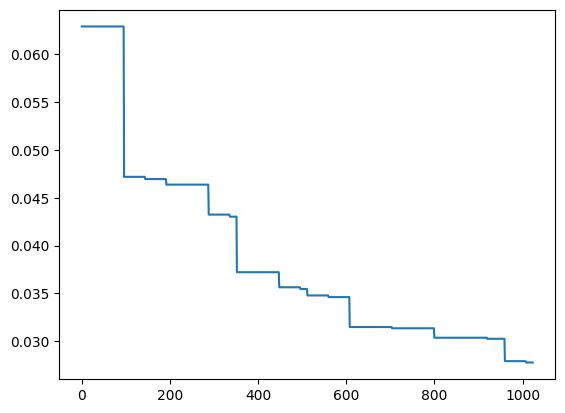

In [109]:
sns.lineplot(x=range(bs.beam_width), y=bs.scores[0])

In [110]:
for i in range(bs.beam_width):
    b = bs.get_beam(i)
    print(b[0])

tensor([ 0, 15,  1, 14,  0,  4,  0, 11,  0,  8,  0, 13,  0, 16,  2,  9,  0,  5,
         6, 19,  3, 10,  7,  0])
tensor([ 0, 15,  1, 14,  0, 11,  0,  4,  0,  8,  0, 13,  0, 16,  2,  9,  0,  5,
         6, 19,  3, 10,  7,  0])
tensor([ 0, 13,  0,  8,  0, 11,  0,  4,  0, 15,  1, 14,  0, 16,  2,  9,  0,  5,
         6, 19,  3, 10,  7,  0])
tensor([ 0,  4,  0, 13,  0,  8,  0, 11,  0, 15,  1, 14,  0, 16,  2,  9,  0,  5,
         6, 19,  3, 10,  7,  0])
tensor([ 0, 13,  0,  4,  0,  8,  0, 11,  0, 15,  1, 14,  0, 16,  2,  9,  0,  5,
         6, 19,  3, 10,  7,  0])
tensor([ 0, 13,  0,  8,  0,  4,  0, 11,  0, 15,  1, 14,  0, 16,  2,  9,  0,  5,
         6, 19,  3, 10,  7,  0])
tensor([ 0, 13,  0, 11,  0,  4,  0,  8,  0, 15,  1, 14,  0, 16,  2,  9,  0,  5,
         6, 19,  3, 10,  7,  0])
tensor([ 0,  8,  0, 13,  0, 11,  0,  4,  0, 15,  1, 14,  0, 16,  2,  9,  0,  5,
         6, 19,  3, 10,  7,  0])
tensor([ 0, 13,  0, 11,  0,  8,  0,  4,  0, 15,  1, 14,  0, 16,  2,  9,  0,  5,
         6, 19, 

tensor([ 0,  4,  0,  8,  0, 15,  1, 14,  0, 11,  0, 13,  0, 16,  2,  9,  0,  5,
         6, 19,  3, 10,  0, 18])
tensor([ 0,  8,  0,  4,  0, 15,  1, 14,  0, 11,  0, 13,  0, 16,  2,  9,  0,  5,
         6, 19,  3, 10,  0, 18])
tensor([ 0,  8,  0, 15,  1, 14,  0,  4,  0, 11,  0, 13,  0, 16,  2,  9,  0,  5,
         6, 19,  3, 10,  0, 18])
tensor([ 0, 11,  0, 15,  1, 14,  0,  8,  0,  4,  0, 13,  0, 16,  2,  9,  0,  5,
         6, 19,  3, 10,  0, 18])
tensor([ 0,  4,  0,  8,  0, 13,  0, 15,  1, 14,  0, 11,  0, 16,  2,  9,  0,  5,
         6, 19,  3, 10,  0, 18])
tensor([ 0,  8,  0,  4,  0, 13,  0, 15,  1, 14,  0, 11,  0, 16,  2,  9,  0,  5,
         6, 19,  3, 10,  0, 18])
tensor([ 0,  8,  0, 13,  0,  4,  0, 15,  1, 14,  0, 11,  0, 16,  2,  9,  0,  5,
         6, 19,  3, 10,  0, 18])
tensor([ 0,  4,  0, 15,  1, 14,  0,  8,  0, 13,  0, 11,  0, 16,  2,  9,  0,  5,
         6, 19,  3, 10,  0, 18])
tensor([ 0, 15,  1, 14,  0,  8,  0,  4,  0, 13,  0, 11,  0, 16,  2,  9,  0,  5,
         6, 19, 

In [22]:
shortest_tours = bs.get_beam(0)
shortest_tours[:2]

tensor([[ 0,  8, 11,  5,  6, 19,  3, 10,  7, 14, 13,  1, 15, 16,  2,  9,  4, 18,
         12, 17,  0,  0,  0,  0],
        [ 0,  9,  8,  6,  1, 12, 19, 16, 11, 17, 18,  7,  3,  4, 15, 10,  2,  5,
         14, 13,  0,  0,  0,  0]])

In [97]:
bs.sanity_check()

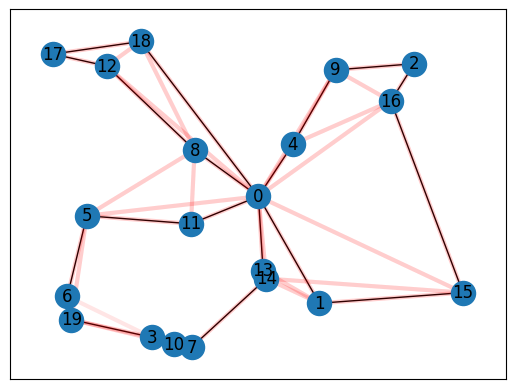

In [60]:
idx = 0

coords_np = coords.cpu().numpy()
preds_np = preds.argmax(dim=3).cpu().numpy()
targets_np = targets.cpu().numpy()

plot_edge_predictions(coords_np[idx], preds_np[idx], targets_np[idx])

In [81]:
y = torch.clone(preds[..., 1])
y[..., 0] *= 0.5

<Axes: >

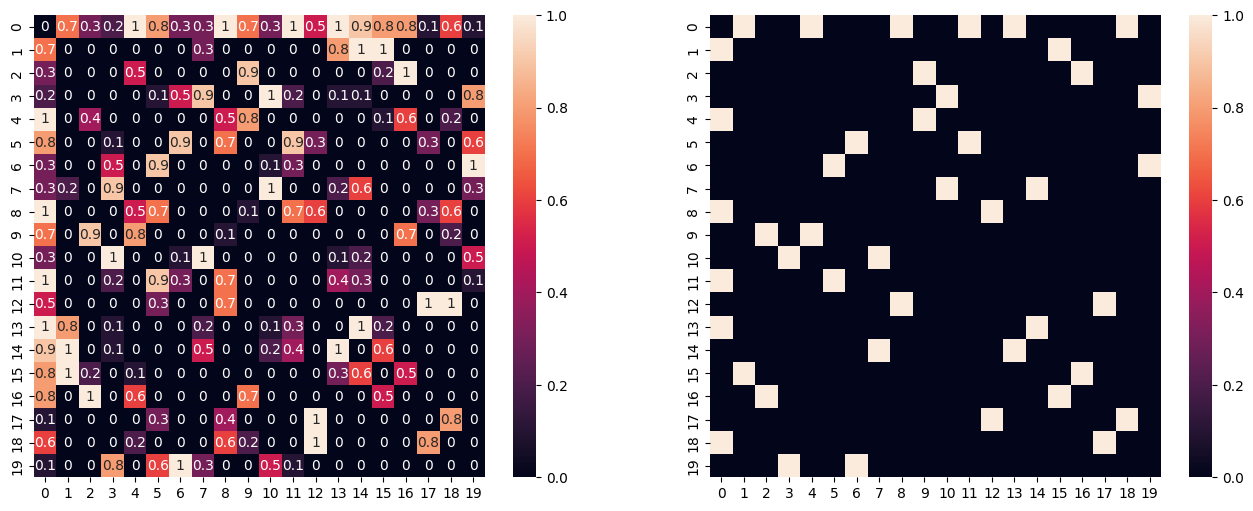

In [98]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(16, 6))

annot = False

sns.heatmap(y_pred[0].cpu().numpy().round(1), annot=True, ax=ax[0])
sns.heatmap(targets_np[0], annot=annot, ax=ax[1])

From the graphic it's clear that the probability from the depot to other nodes is very high, hence the beam search returns the beams where the depot is visited early on. When adjusting these probabilities, beam search finds better solutions with the need for including capacity contraints in the beam search algorithm.

## Tour distance

The code below can serve as a good starting point for calculating the distance of the tour found so far.

In [102]:
# offset by one to calculate total travel distance
idx = (torch.arange(0, shortest_tours.size(1)) + 1) % shortest_tours.size(1)
idx = idx.expand_as(shortest_tours)

In [61]:
shortest_tours.gather(1, x)

tensor([[4, 2, 3, 1, 0],
        [3, 2, 4, 1, 0],
        [4, 3, 1, 2, 0]])